Code to develop Extreme Heat Indicator 2 for the Vulnerable Communities Platform
Data source: https://cadcat.s3.amazonaws.com/index.html#loca2/aaa-ca-hybrid/
Code support via Gemini
Data draws from 5 General Use Projections 
https://www.energy.ca.gov/sites/default/files/2024-10/07_General_Use_Projections_Data_Justification_Sept2024_ada.pdf
and averaged for 2015-2044 and 2045-2074 to provide high level overviews of climate risk/vulnerability. 

In [1]:
import xarray as xr
import numpy as np
import rioxarray  # Import rioxarray for GeoTIFF export
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [3]:
import os

# Get the current working directory (optional)
current_directory = os.getcwd()
#print(f"Current directory: {current_directory}")

# Define the new directory path
new_directory = "I:/loca2/gen_use"  # Replace with your desired path

# Change the directory
try:
    os.chdir(new_directory)
    print(f"Successfully changed directory to: {os.getcwd()}")
except FileNotFoundError:
    print(f"Error: The directory '{new_directory}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

Successfully changed directory to: I:\loca2\gen_use


In [ ]:
#ACCESS CM-2 Data

In [ ]:
def calculate_percentile(file_path, percentile=98):
    """
    Calculates the specified percentile of daily maximum temperature (tasmax) 
    at each grid point in a NetCDF file.

    Args:
        file_path (str): Path to the NetCDF file.
        percentile (int, optional): The percentile to calculate (default: 98).

    Returns:
        xarray.DataArray: A DataArray with dimensions 'lat' and 'lon', containing
                         the calculated percentile of tasmax for each grid point.
                         Returns None if there's an error.
    """
    try:
        ds = xr.open_dataset(file_path)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except Exception as e:
        print(f"Error opening dataset: {e}")
        return None

    # Select June, July, and August
    jja_mask = ds['time.month'].isin([6, 7, 8])
    ds_jja = ds.sel(time=jja_mask)
    
    # Calculate the percentile along the time dimension
    percentile_values = ds_jja['tasmax'].quantile(percentile / 100, dim='time')  # Use quantile directly

    return percentile_values


file_path = "tasmax.ACCESS-CM2.historical.r1i1p1f1.1950-2014.LOCA2_CA_hybrid_v20230115.nc"
percentile_98 = calculate_percentile(file_path, percentile=98)

if percentile_98 is not None:
    print(percentile_98)

    # Save to NetCDF (optional)
    try:
        percentile_98.to_netcdf("VCP_EXHEAT_TMAX_98pct_1950-2014_ACCESS-CM2.nc")
        print("NetCDF file created successfully!")
    except Exception as e:
        print(f"Error exporting to NetCDF: {e}")

In [ ]:
def calculate_percentile(file_path, percentile=98):
    """
    Calculates the specified percentile of daily Min temperature (tasmin) 
    at each grid point in a NetCDF file.
    NOTE: netcdf file of TASMIN has "tasmax_minus_tasmax_minus_tasmin" the variable name
    Args:
        file_path (str): Path to the NetCDF file.
        percentile (int, optional): The percentile to calculate (default: 98).

    Returns:
        xarray.DataArray: A DataArray with dimensions 'lat' and 'lon', containing
                         the calculated percentile of tasmin for each grid point.
                         Returns None if there's an error.
    """
    try:
        ds = xr.open_dataset(file_path)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except Exception as e:
        print(f"Error opening dataset: {e}")
        return None

    # Select June, July, and August
    jja_mask = ds['time.month'].isin([6, 7, 8])
    ds_jja = ds.sel(time=jja_mask)
    
    # Calculate the percentile along the time dimension
    percentile_values = ds_jja['tasmax_minus_tasmax_minus_tasmin'].quantile(percentile / 100, dim='time')  # Use quantile directly

    return percentile_values


file_path = "tasmin.ACCESS-CM2.historical.r1i1p1f1.1950-2014.LOCA2_CA_hybrid_v20230115.nc"
percentile_98 = calculate_percentile(file_path, percentile=98)

if percentile_98 is not None:
    print(percentile_98)

    # Save to NetCDF (optional)
    try:
        percentile_98.to_netcdf("VCP_EXHEAT_TMIN_98pct_1950-2014_ACCESS-CM2.nc")
        print("NetCDF file created successfully!")
    except Exception as e:
        print(f"Error exporting to NetCDF: {e}")

In [ ]:
def count_exceedances(file_path_data, file_path_percentiles):
    """
    Counts the number of days in JJA where daily tasmax exceeds the 98th percentile,
    but only if the 98th percentile value at that lat/lon location is greater than 305.4.

    Args:
        file_path_data (str): Path to the NetCDF file containing daily tasmax (e.g., "Test2.nc").
        file_path_percentiles (str): Path to the NetCDF file containing the pre-calculated 98th percentiles (e.g., "tasmax_98th_percentile.nc").

    Returns:
        xarray.DataArray: A DataArray with dimensions 'lat' and 'lon', containing
                            the count of exceedances. Returns None if there's an error.
    """
    try:
        ds_data = xr.open_dataset(file_path_data)
        ds_percentiles = xr.open_dataset(file_path_percentiles)
        ds_percentiles_mask = xr.open_dataset(file_path_percentiles_mask)

    except FileNotFoundError:
        print(f"Error: One or both files not found.")
        return None
    except Exception as e:
        print(f"Error opening dataset: {e}")
        return None

    # Select June, July, and August
    jja_mask = ds_data['time'].dt.month.isin([6, 7, 8])
    ds_jja = ds_data.sel(time=jja_mask)

    # Create a mask for locations where the 98th percentile is greater than 305.4
    percentile_mask = ds_percentiles_mask['tasmax'] > 305.4

    # Apply the mask to both the percentile and the daily data
    masked_percentiles = ds_percentiles['tasmax_minus_tasmax_minus_tasmin'].where(percentile_mask)

    # Compare daily tasmax with the masked 98th percentile values. Broadcasting is automatic.
    exceedances = ds_jja['tasmax_minus_tasmax_minus_tasmin'] > masked_percentiles

    # Count the number of exceedances at each location
    exceedance_counts = exceedances.groupby('time.dayofyear').sum().sum(dim='dayofyear')

    return exceedance_counts

file_path_data = "tasmin.ACCESS-CM2.ssp370.r1i1p1f1.2015-2044.LOCA2_CA_hybrid_v20230115.nc"  # Replace with your daily data file
file_path_percentiles = "VCP_EXHEAT_TMIN_98pct_1950-2014_ACCESS-CM2.nc"  # Replace with your percentile file
file_path_percentiles_mask = "VCP_EXHEAT_TMAX_98pct_1950-2014_ACCESS-CM2.nc"  # Replace with your percentile file

exceedance_counts = count_exceedances(file_path_data, file_path_percentiles)

if exceedance_counts is not None:
    print(exceedance_counts)

    # Save to NetCDF (optional)
    try:
        exceedance_counts.to_netcdf("VCP_EXHEAT_2A-1_98TMIN_counts_GT90F_2015-2044_ACCESS-CM2.nc")
        print("NetCDF file created successfully!")
    except Exception as e:
        print(f"Error exporting to NetCDF: {e}")

In [ ]:
def count_exceedances(file_path_data, file_path_percentiles):
    """
    Counts the number of days in JJA where daily tasmax exceeds the 98th percentile,
    but only if the 98th percentile value at that lat/lon location is greater than 305.4.

    Args:
        file_path_data (str): Path to the NetCDF file containing daily tasmax (e.g., "Test2.nc").
        file_path_percentiles (str): Path to the NetCDF file containing the pre-calculated 98th percentiles (e.g., "tasmax_98th_percentile.nc").

    Returns:
        xarray.DataArray: A DataArray with dimensions 'lat' and 'lon', containing
                            the count of exceedances. Returns None if there's an error.
    """
    try:
        ds_data = xr.open_dataset(file_path_data)
        ds_percentiles = xr.open_dataset(file_path_percentiles)
        ds_percentiles_mask = xr.open_dataset(file_path_percentiles_mask)

    except FileNotFoundError:
        print(f"Error: One or both files not found.")
        return None
    except Exception as e:
        print(f"Error opening dataset: {e}")
        return None

    # Select June, July, and August
    jja_mask = ds_data['time'].dt.month.isin([6, 7, 8])
    ds_jja = ds_data.sel(time=jja_mask)

    # Create a mask for locations where the 98th percentile is greater than 305.4
    percentile_mask = ds_percentiles_mask['tasmax'] > 305.4

    # Apply the mask to both the percentile and the daily data
    masked_percentiles = ds_percentiles['tasmax_minus_tasmax_minus_tasmin'].where(percentile_mask)

    # Compare daily tasmax with the masked 98th percentile values. Broadcasting is automatic.
    exceedances = ds_jja['tasmax_minus_tasmax_minus_tasmin'] > masked_percentiles

    # Count the number of exceedances at each location
    exceedance_counts = exceedances.groupby('time.dayofyear').sum().sum(dim='dayofyear')

    return exceedance_counts

file_path_data = "tasmin.ACCESS-CM2.ssp370.r1i1p1f1.2045-2074.LOCA2_CA_hybrid_v20230115.nc"  # Replace with your daily data file
file_path_percentiles = "VCP_EXHEAT_TMIN_98pct_1950-2014_ACCESS-CM2.nc"  # Replace with your percentile file
file_path_percentiles_mask = "VCP_EXHEAT_TMAX_98pct_1950-2014_ACCESS-CM2.nc"  # Replace with your percentile file

exceedance_counts = count_exceedances(file_path_data, file_path_percentiles)

if exceedance_counts is not None:
    print(exceedance_counts)

    # Save to NetCDF (optional)
    try:
        exceedance_counts.to_netcdf("VCP_EXHEAT_2B-1_98TMIN_counts_GT90F_2045-2074_ACCESS-CM2.nc")
        print("NetCDF file created successfully!")
    except Exception as e:
        print(f"Error exporting to NetCDF: {e}")

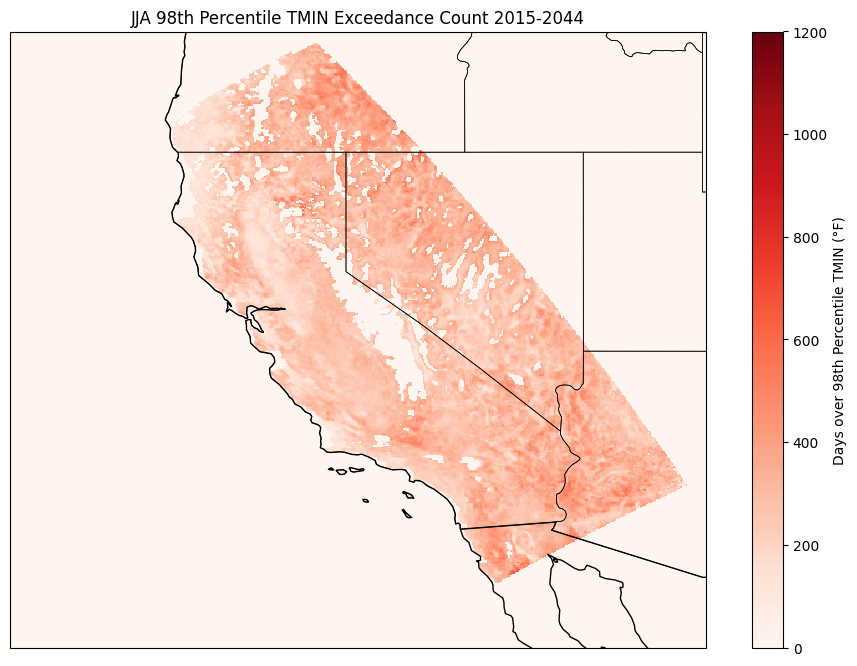

In [7]:
def map_98TMIN(netcdf_file, variable_name="tasmax_minus_tasmax_minus_tasmin", projection=ccrs.PlateCarree(), cmap='Reds'):
    """
    Creates a map of the Tasmin Exceedance Counts from a NetCDF file.

    Args:
        netcdf_file (str): Path to the NetCDF file containing the 100F counts.
        variable_name (str): Name of the variable to plot. Defaults to "tasmax".
        projection (cartopy.crs.Projection): Cartopy projection to use. Defaults to PlateCarree.
        cmap (str): Colormap to use. Defaults to 'RdBu_r'.
    """
    try:
        ds = xr.open_dataset(netcdf_file)
        data = ds[variable_name]

        if 'lat' not in data.coords or 'lon' not in data.coords:
            print("Error: Latitude and longitude coordinates not found.")
            ds.close()
            return

        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=projection)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap,vmax=1200, cbar_kwargs={'label': 'Days over 98th Percentile TMIN (°F)'})

        plt.title("JJA 98th Percentile TMIN Exceedance Count 2015-2044")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {netcdf_file}")
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in the file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'ds' in locals():
            ds.close()

# Example usage (assuming you have the tasmax_diff.nc file from the previous code):
netcdf_file_path = "VCP_EXHEAT_2A-1_98TMIN_counts_GT90F_2015-2044.nc"  # Path to the NetCDF file with the tasmax difference

map_98TMIN(netcdf_file_path)

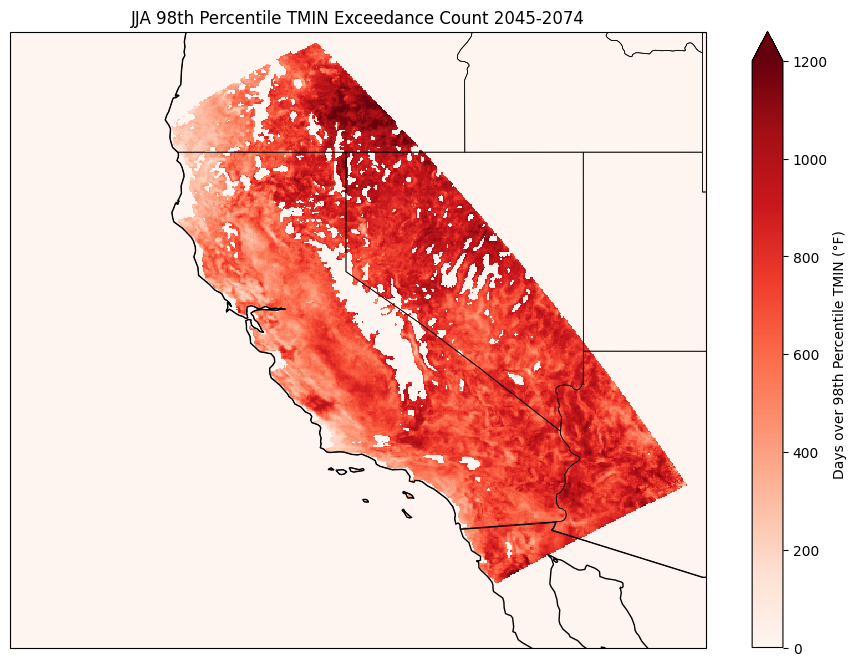

In [9]:
def map_98TMIN(netcdf_file, variable_name="tasmax_minus_tasmax_minus_tasmin", projection=ccrs.PlateCarree(), cmap='Reds'):
    """
    Creates a map of the Tasmin Exceedance Counts from a NetCDF file.

    Args:
        netcdf_file (str): Path to the NetCDF file containing the 100F counts.
        variable_name (str): Name of the variable to plot. Defaults to "tasmax".
        projection (cartopy.crs.Projection): Cartopy projection to use. Defaults to PlateCarree.
        cmap (str): Colormap to use. Defaults to 'RdBu_r'.
    """
    try:
        ds = xr.open_dataset(netcdf_file)
        data = ds[variable_name]

        if 'lat' not in data.coords or 'lon' not in data.coords:
            print("Error: Latitude and longitude coordinates not found.")
            ds.close()
            return

        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=projection)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap,vmax=1200,cbar_kwargs={'label': 'Days over 98th Percentile TMIN (°F)'})

        plt.title("JJA 98th Percentile TMIN Exceedance Count 2045-2074")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {netcdf_file}")
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in the file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'ds' in locals():
            ds.close()

# Example usage (assuming you have the tasmax_diff.nc file from the previous code):
netcdf_file_path = "VCP_EXHEAT_2B-1_98TMIN_counts_GT90F_2045-2074.nc"  # Path to the NetCDF file with the tasmax difference

map_98TMIN(netcdf_file_path)

In [ ]:
#EARTH3 Data

In [22]:
def calculate_percentile(file_path, percentile=98):
    """
    Calculates the specified percentile of daily maximum temperature (tasmax) 
    at each grid point in a NetCDF file.

    Args:
        file_path (str): Path to the NetCDF file.
        percentile (int, optional): The percentile to calculate (default: 98).

    Returns:
        xarray.DataArray: A DataArray with dimensions 'lat' and 'lon', containing
                         the calculated percentile of tasmax for each grid point.
                         Returns None if there's an error.
    """
    try:
        ds = xr.open_dataset(file_path)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except Exception as e:
        print(f"Error opening dataset: {e}")
        return None

    # Select June, July, and August
    jja_mask = ds['time.month'].isin([6, 7, 8])
    ds_jja = ds.sel(time=jja_mask)
    
    # Calculate the percentile along the time dimension
    percentile_values = ds_jja['tasmax'].quantile(percentile / 100, dim='time')  # Use quantile directly

    return percentile_values


file_path = "tasmax.EC-Earth3.historical.r1i1p1f1.1950-2014.LOCA2_CA_hybrid_v20230115.nc"
percentile_98 = calculate_percentile(file_path, percentile=98)

if percentile_98 is not None:
    print(percentile_98)

    # Save to NetCDF (optional)
    try:
        percentile_98.to_netcdf("VCP_EXHEAT_TMAX_98pct_1950-2014_Earth3.nc")
        print("NetCDF file created successfully!")
    except Exception as e:
        print(f"Error exporting to NetCDF: {e}")

C:\Users\Ben\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


<xarray.DataArray 'tasmax' (lat: 495, lon: 559)> Size: 1MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * lat       (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon       (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
    quantile  float64 8B 0.98
NetCDF file created successfully!


In [23]:
def calculate_percentile(file_path, percentile=98):
    """
    Calculates the specified percentile of daily Min temperature (tasmin) 
    at each grid point in a NetCDF file.
    NOTE: netcdf file of TASMIN has "tasmax_minus_tasmax_minus_tasmin" the variable name
    Args:
        file_path (str): Path to the NetCDF file.
        percentile (int, optional): The percentile to calculate (default: 98).

    Returns:
        xarray.DataArray: A DataArray with dimensions 'lat' and 'lon', containing
                         the calculated percentile of tasmin for each grid point.
                         Returns None if there's an error.
    """
    try:
        ds = xr.open_dataset(file_path)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except Exception as e:
        print(f"Error opening dataset: {e}")
        return None

    # Select June, July, and August
    jja_mask = ds['time.month'].isin([6, 7, 8])
    ds_jja = ds.sel(time=jja_mask)
    
    # Calculate the percentile along the time dimension
    percentile_values = ds_jja['tasmax_minus_tasmax_minus_tasmin'].quantile(percentile / 100, dim='time')  # Use quantile directly

    return percentile_values


file_path = "tasmin.EC-Earth3.historical.r1i1p1f1.1950-2014.LOCA2_CA_hybrid_v20230115.nc"
percentile_98 = calculate_percentile(file_path, percentile=98)

if percentile_98 is not None:
    print(percentile_98)

    # Save to NetCDF (optional)
    try:
        percentile_98.to_netcdf("VCP_EXHEAT_TMIN_98pct_1950-2014_Earth3.nc")
        print("NetCDF file created successfully!")
    except Exception as e:
        print(f"Error exporting to NetCDF: {e}")

C:\Users\Ben\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


<xarray.DataArray 'tasmax_minus_tasmax_minus_tasmin' (lat: 495, lon: 559)> Size: 1MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * lat       (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon       (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
    quantile  float64 8B 0.98
NetCDF file created successfully!


In [5]:
def count_exceedances(file_path_data, file_path_percentiles):
    """
    Counts the number of days in JJA where daily tasmax exceeds the 98th percentile,
    but only if the 98th percentile value at that lat/lon location is greater than 305.4.

    Args:
        file_path_data (str): Path to the NetCDF file containing daily tasmax (e.g., "Test2.nc").
        file_path_percentiles (str): Path to the NetCDF file containing the pre-calculated 98th percentiles (e.g., "tasmax_98th_percentile.nc").

    Returns:
        xarray.DataArray: A DataArray with dimensions 'lat' and 'lon', containing
                            the count of exceedances. Returns None if there's an error.
    """
    try:
        ds_data = xr.open_dataset(file_path_data)
        ds_percentiles = xr.open_dataset(file_path_percentiles)
        ds_percentiles_mask = xr.open_dataset(file_path_percentiles_mask)

    except FileNotFoundError:
        print(f"Error: One or both files not found.")
        return None
    except Exception as e:
        print(f"Error opening dataset: {e}")
        return None

    # Select June, July, and August
    jja_mask = ds_data['time'].dt.month.isin([6, 7, 8])
    ds_jja = ds_data.sel(time=jja_mask)

    # Create a mask for locations where the 98th percentile is greater than 305.4
    percentile_mask = ds_percentiles_mask['tasmax'] > 305.4

    # Apply the mask to both the percentile and the daily data
    masked_percentiles = ds_percentiles['tasmax_minus_tasmax_minus_tasmin'].where(percentile_mask)

    # Compare daily tasmax with the masked 98th percentile values. Broadcasting is automatic.
    exceedances = ds_jja['tasmax_minus_tasmax_minus_tasmin'] > masked_percentiles

    # Count the number of exceedances at each location
    exceedance_counts = exceedances.groupby('time.dayofyear').sum().sum(dim='dayofyear')

    return exceedance_counts

file_path_data = "tasmin.EC-Earth3.ssp370.r1i1p1f1.2015-2044.LOCA2_CA_hybrid_v20230115.nc"  # Replace with your daily data file
file_path_percentiles = "VCP_EXHEAT_TMIN_98pct_1950-2014_Earth3.nc"  # Replace with your percentile file
file_path_percentiles_mask = "VCP_EXHEAT_TMAX_98pct_1950-2014_Earth3.nc"  # Replace with your percentile file

exceedance_counts = count_exceedances(file_path_data, file_path_percentiles)

if exceedance_counts is not None:
    print(exceedance_counts)

    # Save to NetCDF (optional)
    try:
        exceedance_counts.to_netcdf("VCP_EXHEAT_2A-2_98TMIN_counts_GT90F_2015-2044_Earth3.nc")
        print("NetCDF file created successfully!")
    except Exception as e:
        print(f"Error exporting to NetCDF: {e}")

C:\Users\Ben\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\Ben\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\Ben\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


<xarray.DataArray 'tasmax_minus_tasmax_minus_tasmin' (lat: 495, lon: 559)> Size: 1MB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * lat       (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon       (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
    quantile  float64 8B 0.98
NetCDF file created successfully!


In [25]:
def count_exceedances(file_path_data, file_path_percentiles):
    """
    Counts the number of days in JJA where daily tasmax exceeds the 98th percentile,
    but only if the 98th percentile value at that lat/lon location is greater than 305.4.

    Args:
        file_path_data (str): Path to the NetCDF file containing daily tasmax (e.g., "Test2.nc").
        file_path_percentiles (str): Path to the NetCDF file containing the pre-calculated 98th percentiles (e.g., "tasmax_98th_percentile.nc").

    Returns:
        xarray.DataArray: A DataArray with dimensions 'lat' and 'lon', containing
                            the count of exceedances. Returns None if there's an error.
    """
    try:
        ds_data = xr.open_dataset(file_path_data)
        ds_percentiles = xr.open_dataset(file_path_percentiles)
        ds_percentiles_mask = xr.open_dataset(file_path_percentiles_mask)

    except FileNotFoundError:
        print(f"Error: One or both files not found.")
        return None
    except Exception as e:
        print(f"Error opening dataset: {e}")
        return None

    # Select June, July, and August
    jja_mask = ds_data['time'].dt.month.isin([6, 7, 8])
    ds_jja = ds_data.sel(time=jja_mask)

    # Create a mask for locations where the 98th percentile is greater than 305.4
    percentile_mask = ds_percentiles_mask['tasmax'] > 305.4

    # Apply the mask to both the percentile and the daily data
    masked_percentiles = ds_percentiles['tasmax_minus_tasmax_minus_tasmin'].where(percentile_mask)

    # Compare daily tasmax with the masked 98th percentile values. Broadcasting is automatic.
    exceedances = ds_jja['tasmax_minus_tasmax_minus_tasmin'] > masked_percentiles

    # Count the number of exceedances at each location
    exceedance_counts = exceedances.groupby('time.dayofyear').sum().sum(dim='dayofyear')

    return exceedance_counts

file_path_data = "tasmin.EC-Earth3.ssp370.r1i1p1f1.2045-2074.LOCA2_CA_hybrid_v20230115.nc"  # Replace with your daily data file
file_path_percentiles = "VCP_EXHEAT_TMIN_98pct_1950-2014_Earth3.nc"  # Replace with your percentile file
file_path_percentiles_mask = "VCP_EXHEAT_TMAX_98pct_1950-2014_Earth3.nc"  # Replace with your percentile file

exceedance_counts = count_exceedances(file_path_data, file_path_percentiles)

if exceedance_counts is not None:
    print(exceedance_counts)

    # Save to NetCDF (optional)
    try:
        exceedance_counts.to_netcdf("VCP_EXHEAT_2A-2_98TMIN_counts_GT90F_2045-2074_Earth3.nc")
        print("NetCDF file created successfully!")
    except Exception as e:
        print(f"Error exporting to NetCDF: {e}")

<xarray.DataArray 'tasmax_minus_tasmax_minus_tasmin' (lat: 495, lon: 559)> Size: 1MB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * lat       (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon       (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
    quantile  float64 8B 0.98
NetCDF file created successfully!


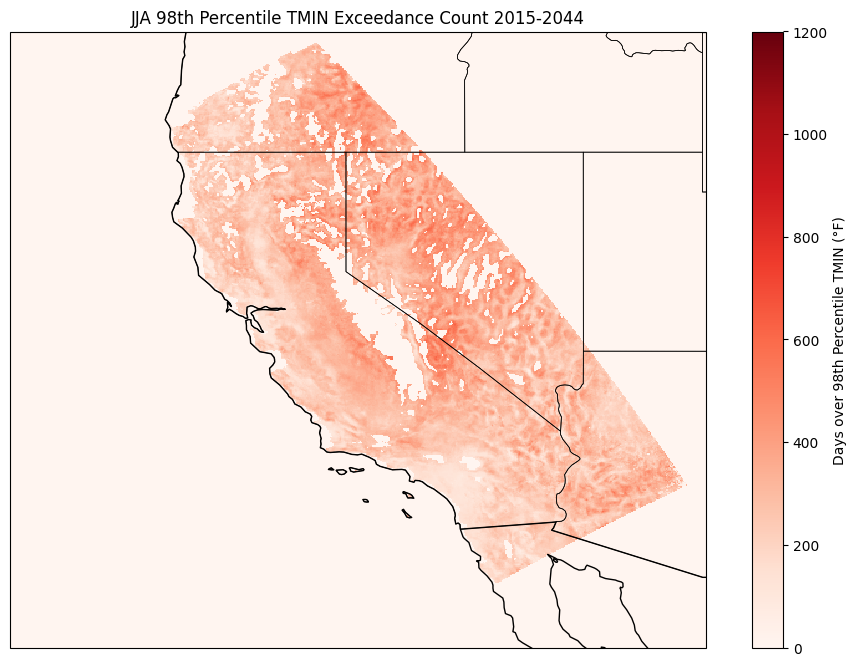

In [26]:
def map_98TMIN(netcdf_file, variable_name="tasmax_minus_tasmax_minus_tasmin", projection=ccrs.PlateCarree(), cmap='Reds'):
    """
    Creates a map of the Tasmin Exceedance Counts from a NetCDF file.

    Args:
        netcdf_file (str): Path to the NetCDF file containing the 100F counts.
        variable_name (str): Name of the variable to plot. Defaults to "tasmax".
        projection (cartopy.crs.Projection): Cartopy projection to use. Defaults to PlateCarree.
        cmap (str): Colormap to use. Defaults to 'RdBu_r'.
    """
    try:
        ds = xr.open_dataset(netcdf_file)
        data = ds[variable_name]

        if 'lat' not in data.coords or 'lon' not in data.coords:
            print("Error: Latitude and longitude coordinates not found.")
            ds.close()
            return

        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=projection)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap,vmax=1200, cbar_kwargs={'label': 'Days over 98th Percentile TMIN (°F)'})

        plt.title("JJA 98th Percentile TMIN Exceedance Count 2015-2044")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {netcdf_file}")
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in the file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'ds' in locals():
            ds.close()

# Example usage (assuming you have the tasmax_diff.nc file from the previous code):
netcdf_file_path = "VCP_EXHEAT_2A-2_98TMIN_counts_GT90F_2015-2044_Earth3.nc"  # Path to the NetCDF file with the tasmax difference

map_98TMIN(netcdf_file_path)

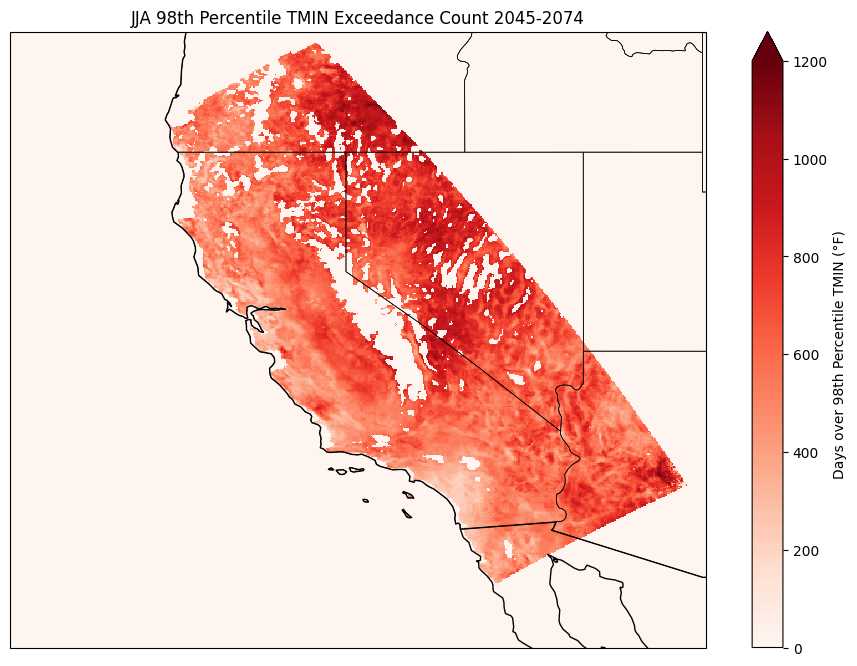

In [28]:
def map_98TMIN(netcdf_file, variable_name="tasmax_minus_tasmax_minus_tasmin", projection=ccrs.PlateCarree(), cmap='Reds'):
    """
    Creates a map of the Tasmin Exceedance Counts from a NetCDF file.

    Args:
        netcdf_file (str): Path to the NetCDF file containing the 100F counts.
        variable_name (str): Name of the variable to plot. Defaults to "tasmax".
        projection (cartopy.crs.Projection): Cartopy projection to use. Defaults to PlateCarree.
        cmap (str): Colormap to use. Defaults to 'RdBu_r'.
    """
    try:
        ds = xr.open_dataset(netcdf_file)
        data = ds[variable_name]

        if 'lat' not in data.coords or 'lon' not in data.coords:
            print("Error: Latitude and longitude coordinates not found.")
            ds.close()
            return

        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=projection)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap,vmax=1200,cbar_kwargs={'label': 'Days over 98th Percentile TMIN (°F)'})

        plt.title("JJA 98th Percentile TMIN Exceedance Count 2045-2074")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {netcdf_file}")
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in the file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'ds' in locals():
            ds.close()

# Example usage (assuming you have the tasmax_diff.nc file from the previous code):
netcdf_file_path = "VCP_EXHEAT_2A-2_98TMIN_counts_GT90F_2045-2074_Earth3.nc"  # Path to the NetCDF file with the tasmax difference

map_98TMIN(netcdf_file_path)

In [ ]:
#FGOALS Data

In [72]:
def calculate_percentile(file_path, percentile=98):
    """
    Calculates the specified percentile of daily maximum temperature (tasmax) 
    at each grid point in a NetCDF file.

    Args:
        file_path (str): Path to the NetCDF file.
        percentile (int, optional): The percentile to calculate (default: 98).

    Returns:
        xarray.DataArray: A DataArray with dimensions 'lat' and 'lon', containing
                         the calculated percentile of tasmax for each grid point.
                         Returns None if there's an error.
    """
    try:
        ds = xr.open_dataset(file_path)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except Exception as e:
        print(f"Error opening dataset: {e}")
        return None

    # Select June, July, and August
    jja_mask = ds['time.month'].isin([6, 7, 8])
    ds_jja = ds.sel(time=jja_mask)
    
    # Calculate the percentile along the time dimension
    percentile_values = ds_jja['tasmax'].quantile(percentile / 100, dim='time')  # Use quantile directly

    return percentile_values


file_path = "tasmax.FGOALS-g3.historical.r1i1p1f1.1950-2014.LOCA2_CA_hybrid_v20230115.nc"
percentile_98 = calculate_percentile(file_path, percentile=98)

if percentile_98 is not None:
    print(percentile_98)

    # Save to NetCDF (optional)
    try:
        percentile_98.to_netcdf("VCP_EXHEAT_TMAX_98pct_1950-2014_FGOALS.nc")
        print("NetCDF file created successfully!")
    except Exception as e:
        print(f"Error exporting to NetCDF: {e}")

C:\Users\Ben\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


<xarray.DataArray 'tasmax' (lat: 495, lon: 559)> Size: 1MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * lat       (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon       (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
    quantile  float64 8B 0.98
NetCDF file created successfully!


In [73]:
def calculate_percentile(file_path, percentile=98):
    """
    Calculates the specified percentile of daily Min temperature (tasmin) 
    at each grid point in a NetCDF file.
    NOTE: netcdf file of TASMIN has "tasmax_minus_tasmax_minus_tasmin" the variable name
    Args:
        file_path (str): Path to the NetCDF file.
        percentile (int, optional): The percentile to calculate (default: 98).

    Returns:
        xarray.DataArray: A DataArray with dimensions 'lat' and 'lon', containing
                         the calculated percentile of tasmin for each grid point.
                         Returns None if there's an error.
    """
    try:
        ds = xr.open_dataset(file_path)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except Exception as e:
        print(f"Error opening dataset: {e}")
        return None

    # Select June, July, and August
    jja_mask = ds['time.month'].isin([6, 7, 8])
    ds_jja = ds.sel(time=jja_mask)
    
    # Calculate the percentile along the time dimension
    percentile_values = ds_jja['tasmax_minus_tasmax_minus_tasmin'].quantile(percentile / 100, dim='time')  # Use quantile directly

    return percentile_values


file_path = "tasmin.FGOALS-g3.historical.r1i1p1f1.1950-2014.LOCA2_CA_hybrid_v20230115.nc"
percentile_98 = calculate_percentile(file_path, percentile=98)

if percentile_98 is not None:
    print(percentile_98)

    # Save to NetCDF (optional)
    try:
        percentile_98.to_netcdf("VCP_EXHEAT_TMIN_98pct_1950-2014_FGOALS.nc")
        print("NetCDF file created successfully!")
    except Exception as e:
        print(f"Error exporting to NetCDF: {e}")

C:\Users\Ben\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


<xarray.DataArray 'tasmax_minus_tasmax_minus_tasmin' (lat: 495, lon: 559)> Size: 1MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * lat       (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon       (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
    quantile  float64 8B 0.98
NetCDF file created successfully!


In [74]:
def count_exceedances(file_path_data, file_path_percentiles):
    """
    Counts the number of days in JJA where daily tasmax exceeds the 98th percentile,
    but only if the 98th percentile value at that lat/lon location is greater than 305.4.

    Args:
        file_path_data (str): Path to the NetCDF file containing daily tasmax (e.g., "Test2.nc").
        file_path_percentiles (str): Path to the NetCDF file containing the pre-calculated 98th percentiles (e.g., "tasmax_98th_percentile.nc").

    Returns:
        xarray.DataArray: A DataArray with dimensions 'lat' and 'lon', containing
                            the count of exceedances. Returns None if there's an error.
    """
    try:
        ds_data = xr.open_dataset(file_path_data)
        ds_percentiles = xr.open_dataset(file_path_percentiles)
        ds_percentiles_mask = xr.open_dataset(file_path_percentiles_mask)

    except FileNotFoundError:
        print(f"Error: One or both files not found.")
        return None
    except Exception as e:
        print(f"Error opening dataset: {e}")
        return None

    # Select June, July, and August
    jja_mask = ds_data['time'].dt.month.isin([6, 7, 8])
    ds_jja = ds_data.sel(time=jja_mask)

    # Create a mask for locations where the 98th percentile is greater than 305.4
    percentile_mask = ds_percentiles_mask['tasmax'] > 305.4

    # Apply the mask to both the percentile and the daily data
    masked_percentiles = ds_percentiles['tasmax_minus_tasmax_minus_tasmin'].where(percentile_mask)

    # Compare daily tasmax with the masked 98th percentile values. Broadcasting is automatic.
    exceedances = ds_jja['tasmax_minus_tasmax_minus_tasmin'] > masked_percentiles

    # Count the number of exceedances at each location
    exceedance_counts = exceedances.groupby('time.dayofyear').sum().sum(dim='dayofyear')

    return exceedance_counts

file_path_data = "tasmin.FGOALS-g3.ssp370.r1i1p1f1.2015-2044.LOCA2_CA_hybrid_v20230115.nc"  # Replace with your daily data file
file_path_percentiles = "VCP_EXHEAT_TMIN_98pct_1950-2014_FGOALS.nc"  # Replace with your percentile file
file_path_percentiles_mask = "VCP_EXHEAT_TMAX_98pct_1950-2014_FGOALS.nc"  # Replace with your percentile file

exceedance_counts = count_exceedances(file_path_data, file_path_percentiles)

if exceedance_counts is not None:
    print(exceedance_counts)

    # Save to NetCDF (optional)
    try:
        exceedance_counts.to_netcdf("VCP_EXHEAT_2A-3_98TMIN_counts_GT90F_2015-2044_FGOALS.nc")
        print("NetCDF file created successfully!")
    except Exception as e:
        print(f"Error exporting to NetCDF: {e}")

<xarray.DataArray 'tasmax_minus_tasmax_minus_tasmin' (lat: 495, lon: 559)> Size: 1MB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * lat       (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon       (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
    quantile  float64 8B 0.98
NetCDF file created successfully!


In [75]:
def count_exceedances(file_path_data, file_path_percentiles):
    """
    Counts the number of days in JJA where daily tasmax exceeds the 98th percentile,
    but only if the 98th percentile value at that lat/lon location is greater than 305.4.

    Args:
        file_path_data (str): Path to the NetCDF file containing daily tasmax (e.g., "Test2.nc").
        file_path_percentiles (str): Path to the NetCDF file containing the pre-calculated 98th percentiles (e.g., "tasmax_98th_percentile.nc").

    Returns:
        xarray.DataArray: A DataArray with dimensions 'lat' and 'lon', containing
                            the count of exceedances. Returns None if there's an error.
    """
    try:
        ds_data = xr.open_dataset(file_path_data)
        ds_percentiles = xr.open_dataset(file_path_percentiles)
        ds_percentiles_mask = xr.open_dataset(file_path_percentiles_mask)

    except FileNotFoundError:
        print(f"Error: One or both files not found.")
        return None
    except Exception as e:
        print(f"Error opening dataset: {e}")
        return None

    # Select June, July, and August
    jja_mask = ds_data['time'].dt.month.isin([6, 7, 8])
    ds_jja = ds_data.sel(time=jja_mask)

    # Create a mask for locations where the 98th percentile is greater than 305.4
    percentile_mask = ds_percentiles_mask['tasmax'] > 305.4

    # Apply the mask to both the percentile and the daily data
    masked_percentiles = ds_percentiles['tasmax_minus_tasmax_minus_tasmin'].where(percentile_mask)

    # Compare daily tasmax with the masked 98th percentile values. Broadcasting is automatic.
    exceedances = ds_jja['tasmax_minus_tasmax_minus_tasmin'] > masked_percentiles

    # Count the number of exceedances at each location
    exceedance_counts = exceedances.groupby('time.dayofyear').sum().sum(dim='dayofyear')

    return exceedance_counts

file_path_data = "tasmin.FGOALS-g3.ssp370.r1i1p1f1.2045-2074.LOCA2_CA_hybrid_v20230115.nc"  # Replace with your daily data file
file_path_percentiles = "VCP_EXHEAT_TMIN_98pct_1950-2014_FGOALS.nc"  # Replace with your percentile file
file_path_percentiles_mask = "VCP_EXHEAT_TMAX_98pct_1950-2014_FGOALS.nc"  # Replace with your percentile file

exceedance_counts = count_exceedances(file_path_data, file_path_percentiles)

if exceedance_counts is not None:
    print(exceedance_counts)

    # Save to NetCDF (optional)
    try:
        exceedance_counts.to_netcdf("VCP_EXHEAT_2A-3_98TMIN_counts_GT90F_2045-2074_FGOALS.nc")
        print("NetCDF file created successfully!")
    except Exception as e:
        print(f"Error exporting to NetCDF: {e}")

<xarray.DataArray 'tasmax_minus_tasmax_minus_tasmin' (lat: 495, lon: 559)> Size: 1MB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * lat       (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon       (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
    quantile  float64 8B 0.98
NetCDF file created successfully!


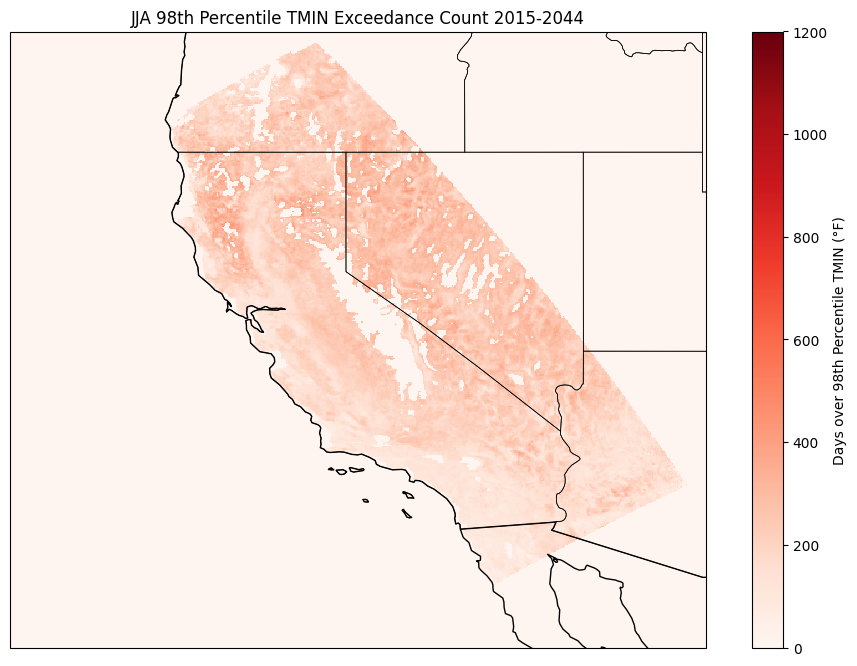

In [76]:
def map_98TMIN(netcdf_file, variable_name="tasmax_minus_tasmax_minus_tasmin", projection=ccrs.PlateCarree(), cmap='Reds'):
    """
    Creates a map of the Tasmin Exceedance Counts from a NetCDF file.

    Args:
        netcdf_file (str): Path to the NetCDF file containing the 100F counts.
        variable_name (str): Name of the variable to plot. Defaults to "tasmax".
        projection (cartopy.crs.Projection): Cartopy projection to use. Defaults to PlateCarree.
        cmap (str): Colormap to use. Defaults to 'RdBu_r'.
    """
    try:
        ds = xr.open_dataset(netcdf_file)
        data = ds[variable_name]

        if 'lat' not in data.coords or 'lon' not in data.coords:
            print("Error: Latitude and longitude coordinates not found.")
            ds.close()
            return

        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=projection)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap,vmax=1200, cbar_kwargs={'label': 'Days over 98th Percentile TMIN (°F)'})

        plt.title("JJA 98th Percentile TMIN Exceedance Count 2015-2044")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {netcdf_file}")
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in the file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'ds' in locals():
            ds.close()

# Example usage (assuming you have the tasmax_diff.nc file from the previous code):
netcdf_file_path = "VCP_EXHEAT_2A-3_98TMIN_counts_GT90F_2015-2044_FGOALS.nc"  # Path to the NetCDF file with the tasmax difference

map_98TMIN(netcdf_file_path)

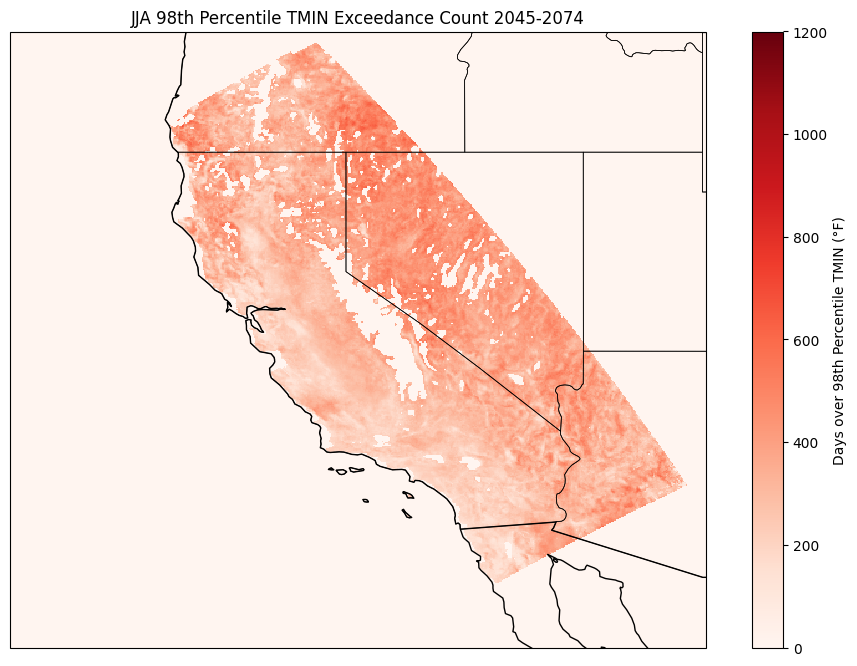

In [77]:
def map_98TMIN(netcdf_file, variable_name="tasmax_minus_tasmax_minus_tasmin", projection=ccrs.PlateCarree(), cmap='Reds'):
    """
    Creates a map of the Tasmin Exceedance Counts from a NetCDF file.

    Args:
        netcdf_file (str): Path to the NetCDF file containing the 100F counts.
        variable_name (str): Name of the variable to plot. Defaults to "tasmax".
        projection (cartopy.crs.Projection): Cartopy projection to use. Defaults to PlateCarree.
        cmap (str): Colormap to use. Defaults to 'RdBu_r'.
    """
    try:
        ds = xr.open_dataset(netcdf_file)
        data = ds[variable_name]

        if 'lat' not in data.coords or 'lon' not in data.coords:
            print("Error: Latitude and longitude coordinates not found.")
            ds.close()
            return

        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=projection)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap,vmax=1200,cbar_kwargs={'label': 'Days over 98th Percentile TMIN (°F)'})

        plt.title("JJA 98th Percentile TMIN Exceedance Count 2045-2074")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {netcdf_file}")
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in the file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'ds' in locals():
            ds.close()

# Example usage (assuming you have the tasmax_diff.nc file from the previous code):
netcdf_file_path = "VCP_EXHEAT_2A-3_98TMIN_counts_GT90F_2045-2074_FGOALS.nc"  # Path to the NetCDF file with the tasmax difference

map_98TMIN(netcdf_file_path)

In [ ]:
#MIROC6 Data

In [85]:
def calculate_percentile(file_path, percentile=98):
    """
    Calculates the specified percentile of daily maximum temperature (tasmax) 
    at each grid point in a NetCDF file.

    Args:
        file_path (str): Path to the NetCDF file.
        percentile (int, optional): The percentile to calculate (default: 98).

    Returns:
        xarray.DataArray: A DataArray with dimensions 'lat' and 'lon', containing
                         the calculated percentile of tasmax for each grid point.
                         Returns None if there's an error.
    """
    try:
        ds = xr.open_dataset(file_path)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except Exception as e:
        print(f"Error opening dataset: {e}")
        return None

    # Select June, July, and August
    jja_mask = ds['time.month'].isin([6, 7, 8])
    ds_jja = ds.sel(time=jja_mask)
    
    # Calculate the percentile along the time dimension
    percentile_values = ds_jja['tasmax'].quantile(percentile / 100, dim='time')  # Use quantile directly

    return percentile_values


file_path = "tasmax.MIROC6.historical.r1i1p1f1.1950-2014.LOCA2_CA_hybrid_v20230115.nc"
percentile_98 = calculate_percentile(file_path, percentile=98)

if percentile_98 is not None:
    print(percentile_98)

    # Save to NetCDF (optional)
    try:
        percentile_98.to_netcdf("VCP_EXHEAT_TMAX_98pct_1950-2014_MIROC6.nc")
        print("NetCDF file created successfully!")
    except Exception as e:
        print(f"Error exporting to NetCDF: {e}")

C:\Users\Ben\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


<xarray.DataArray 'tasmax' (lat: 495, lon: 559)> Size: 1MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * lat       (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon       (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
    quantile  float64 8B 0.98
NetCDF file created successfully!


In [86]:
def calculate_percentile(file_path, percentile=98):
    """
    Calculates the specified percentile of daily Min temperature (tasmin) 
    at each grid point in a NetCDF file.
    NOTE: netcdf file of TASMIN has "tasmax_minus_tasmax_minus_tasmin" the variable name
    Args:
        file_path (str): Path to the NetCDF file.
        percentile (int, optional): The percentile to calculate (default: 98).

    Returns:
        xarray.DataArray: A DataArray with dimensions 'lat' and 'lon', containing
                         the calculated percentile of tasmin for each grid point.
                         Returns None if there's an error.
    """
    try:
        ds = xr.open_dataset(file_path)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except Exception as e:
        print(f"Error opening dataset: {e}")
        return None

    # Select June, July, and August
    jja_mask = ds['time.month'].isin([6, 7, 8])
    ds_jja = ds.sel(time=jja_mask)
    
    # Calculate the percentile along the time dimension
    percentile_values = ds_jja['tasmax_minus_tasmax_minus_tasmin'].quantile(percentile / 100, dim='time')  # Use quantile directly

    return percentile_values


file_path = "tasmin.MIROC6.historical.r1i1p1f1.1950-2014.LOCA2_CA_hybrid_v20230115.nc"
percentile_98 = calculate_percentile(file_path, percentile=98)

if percentile_98 is not None:
    print(percentile_98)

    # Save to NetCDF (optional)
    try:
        percentile_98.to_netcdf("VCP_EXHEAT_TMIN_98pct_1950-2014_MIROC6.nc")
        print("NetCDF file created successfully!")
    except Exception as e:
        print(f"Error exporting to NetCDF: {e}")

C:\Users\Ben\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


<xarray.DataArray 'tasmax_minus_tasmax_minus_tasmin' (lat: 495, lon: 559)> Size: 1MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * lat       (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon       (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
    quantile  float64 8B 0.98
NetCDF file created successfully!


In [87]:
def count_exceedances(file_path_data, file_path_percentiles):
    """
    Counts the number of days in JJA where daily tasmax exceeds the 98th percentile,
    but only if the 98th percentile value at that lat/lon location is greater than 305.4.

    Args:
        file_path_data (str): Path to the NetCDF file containing daily tasmax (e.g., "Test2.nc").
        file_path_percentiles (str): Path to the NetCDF file containing the pre-calculated 98th percentiles (e.g., "tasmax_98th_percentile.nc").

    Returns:
        xarray.DataArray: A DataArray with dimensions 'lat' and 'lon', containing
                            the count of exceedances. Returns None if there's an error.
    """
    try:
        ds_data = xr.open_dataset(file_path_data)
        ds_percentiles = xr.open_dataset(file_path_percentiles)
        ds_percentiles_mask = xr.open_dataset(file_path_percentiles_mask)

    except FileNotFoundError:
        print(f"Error: One or both files not found.")
        return None
    except Exception as e:
        print(f"Error opening dataset: {e}")
        return None

    # Select June, July, and August
    jja_mask = ds_data['time'].dt.month.isin([6, 7, 8])
    ds_jja = ds_data.sel(time=jja_mask)

    # Create a mask for locations where the 98th percentile is greater than 305.4
    percentile_mask = ds_percentiles_mask['tasmax'] > 305.4

    # Apply the mask to both the percentile and the daily data
    masked_percentiles = ds_percentiles['tasmax_minus_tasmax_minus_tasmin'].where(percentile_mask)

    # Compare daily tasmax with the masked 98th percentile values. Broadcasting is automatic.
    exceedances = ds_jja['tasmax_minus_tasmax_minus_tasmin'] > masked_percentiles

    # Count the number of exceedances at each location
    exceedance_counts = exceedances.groupby('time.dayofyear').sum().sum(dim='dayofyear')

    return exceedance_counts

file_path_data = "tasmin.MIROC6.ssp370.r1i1p1f1.2015-2044.LOCA2_CA_hybrid_v20230115.nc"  # Replace with your daily data file
file_path_percentiles = "VCP_EXHEAT_TMIN_98pct_1950-2014_MIROC6.nc"  # Replace with your percentile file
file_path_percentiles_mask = "VCP_EXHEAT_TMAX_98pct_1950-2014_MIROC6.nc"  # Replace with your percentile file

exceedance_counts = count_exceedances(file_path_data, file_path_percentiles)

if exceedance_counts is not None:
    print(exceedance_counts)

    # Save to NetCDF (optional)
    try:
        exceedance_counts.to_netcdf("VCP_EXHEAT_2A-4_98TMIN_counts_GT90F_2015-2044_MIROC6.nc")
        print("NetCDF file created successfully!")
    except Exception as e:
        print(f"Error exporting to NetCDF: {e}")

<xarray.DataArray 'tasmax_minus_tasmax_minus_tasmin' (lat: 495, lon: 559)> Size: 1MB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * lat       (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon       (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
    quantile  float64 8B 0.98
NetCDF file created successfully!


In [88]:
def count_exceedances(file_path_data, file_path_percentiles):
    """
    Counts the number of days in JJA where daily tasmax exceeds the 98th percentile,
    but only if the 98th percentile value at that lat/lon location is greater than 305.4.

    Args:
        file_path_data (str): Path to the NetCDF file containing daily tasmax (e.g., "Test2.nc").
        file_path_percentiles (str): Path to the NetCDF file containing the pre-calculated 98th percentiles (e.g., "tasmax_98th_percentile.nc").

    Returns:
        xarray.DataArray: A DataArray with dimensions 'lat' and 'lon', containing
                            the count of exceedances. Returns None if there's an error.
    """
    try:
        ds_data = xr.open_dataset(file_path_data)
        ds_percentiles = xr.open_dataset(file_path_percentiles)
        ds_percentiles_mask = xr.open_dataset(file_path_percentiles_mask)

    except FileNotFoundError:
        print(f"Error: One or both files not found.")
        return None
    except Exception as e:
        print(f"Error opening dataset: {e}")
        return None

    # Select June, July, and August
    jja_mask = ds_data['time'].dt.month.isin([6, 7, 8])
    ds_jja = ds_data.sel(time=jja_mask)

    # Create a mask for locations where the 98th percentile is greater than 305.4
    percentile_mask = ds_percentiles_mask['tasmax'] > 305.4

    # Apply the mask to both the percentile and the daily data
    masked_percentiles = ds_percentiles['tasmax_minus_tasmax_minus_tasmin'].where(percentile_mask)

    # Compare daily tasmax with the masked 98th percentile values. Broadcasting is automatic.
    exceedances = ds_jja['tasmax_minus_tasmax_minus_tasmin'] > masked_percentiles

    # Count the number of exceedances at each location
    exceedance_counts = exceedances.groupby('time.dayofyear').sum().sum(dim='dayofyear')

    return exceedance_counts

file_path_data = "tasmin.MIROC6.ssp370.r1i1p1f1.2045-2074.LOCA2_CA_hybrid_v20230115.nc"  # Replace with your daily data file
file_path_percentiles = "VCP_EXHEAT_TMIN_98pct_1950-2014_MIROC6.nc"  # Replace with your percentile file
file_path_percentiles_mask = "VCP_EXHEAT_TMAX_98pct_1950-2014_MIROC6.nc"  # Replace with your percentile file

exceedance_counts = count_exceedances(file_path_data, file_path_percentiles)

if exceedance_counts is not None:
    print(exceedance_counts)

    # Save to NetCDF (optional)
    try:
        exceedance_counts.to_netcdf("VCP_EXHEAT_2A-4_98TMIN_counts_GT90F_2045-2074_MIROC6.nc")
        print("NetCDF file created successfully!")
    except Exception as e:
        print(f"Error exporting to NetCDF: {e}")

<xarray.DataArray 'tasmax_minus_tasmax_minus_tasmin' (lat: 495, lon: 559)> Size: 1MB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * lat       (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon       (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
    quantile  float64 8B 0.98
NetCDF file created successfully!


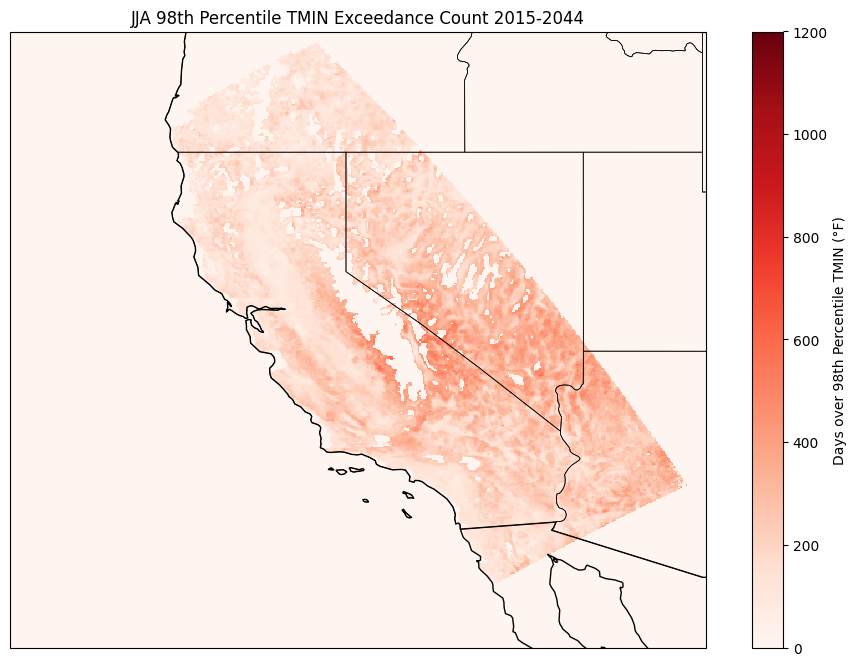

In [89]:
def map_98TMIN(netcdf_file, variable_name="tasmax_minus_tasmax_minus_tasmin", projection=ccrs.PlateCarree(), cmap='Reds'):
    """
    Creates a map of the Tasmin Exceedance Counts from a NetCDF file.

    Args:
        netcdf_file (str): Path to the NetCDF file containing the 100F counts.
        variable_name (str): Name of the variable to plot. Defaults to "tasmax".
        projection (cartopy.crs.Projection): Cartopy projection to use. Defaults to PlateCarree.
        cmap (str): Colormap to use. Defaults to 'RdBu_r'.
    """
    try:
        ds = xr.open_dataset(netcdf_file)
        data = ds[variable_name]

        if 'lat' not in data.coords or 'lon' not in data.coords:
            print("Error: Latitude and longitude coordinates not found.")
            ds.close()
            return

        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=projection)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap,vmax=1200, cbar_kwargs={'label': 'Days over 98th Percentile TMIN (°F)'})

        plt.title("JJA 98th Percentile TMIN Exceedance Count 2015-2044")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {netcdf_file}")
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in the file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'ds' in locals():
            ds.close()

# Example usage (assuming you have the tasmax_diff.nc file from the previous code):
netcdf_file_path = "VCP_EXHEAT_2A-4_98TMIN_counts_GT90F_2015-2044_MIROC6.nc"  # Path to the NetCDF file with the tasmax difference

map_98TMIN(netcdf_file_path)

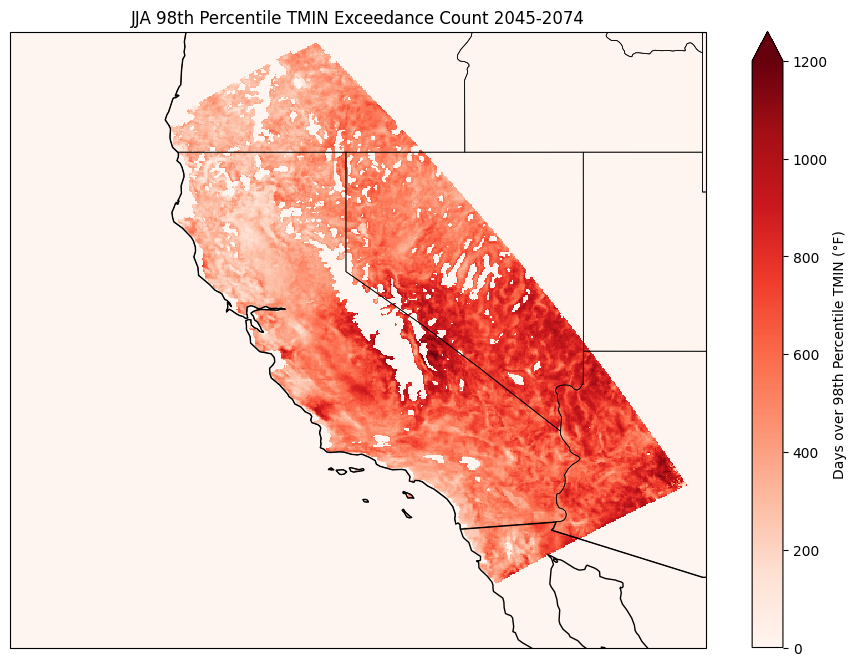

In [90]:
def map_98TMIN(netcdf_file, variable_name="tasmax_minus_tasmax_minus_tasmin", projection=ccrs.PlateCarree(), cmap='Reds'):
    """
    Creates a map of the Tasmin Exceedance Counts from a NetCDF file.

    Args:
        netcdf_file (str): Path to the NetCDF file containing the 100F counts.
        variable_name (str): Name of the variable to plot. Defaults to "tasmax".
        projection (cartopy.crs.Projection): Cartopy projection to use. Defaults to PlateCarree.
        cmap (str): Colormap to use. Defaults to 'RdBu_r'.
    """
    try:
        ds = xr.open_dataset(netcdf_file)
        data = ds[variable_name]

        if 'lat' not in data.coords or 'lon' not in data.coords:
            print("Error: Latitude and longitude coordinates not found.")
            ds.close()
            return

        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=projection)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap,vmax=1200,cbar_kwargs={'label': 'Days over 98th Percentile TMIN (°F)'})

        plt.title("JJA 98th Percentile TMIN Exceedance Count 2045-2074")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {netcdf_file}")
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in the file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'ds' in locals():
            ds.close()

# Example usage (assuming you have the tasmax_diff.nc file from the previous code):
netcdf_file_path = "VCP_EXHEAT_2A-4_98TMIN_counts_GT90F_2045-2074_MIROC6.nc"  # Path to the NetCDF file with the tasmax difference

map_98TMIN(netcdf_file_path)

In [ ]:
#MPI Data

In [98]:
def calculate_percentile(file_path, percentile=98):
    """
    Calculates the specified percentile of daily maximum temperature (tasmax) 
    at each grid point in a NetCDF file.

    Args:
        file_path (str): Path to the NetCDF file.
        percentile (int, optional): The percentile to calculate (default: 98).

    Returns:
        xarray.DataArray: A DataArray with dimensions 'lat' and 'lon', containing
                         the calculated percentile of tasmax for each grid point.
                         Returns None if there's an error.
    """
    try:
        ds = xr.open_dataset(file_path)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except Exception as e:
        print(f"Error opening dataset: {e}")
        return None

    # Select June, July, and August
    jja_mask = ds['time.month'].isin([6, 7, 8])
    ds_jja = ds.sel(time=jja_mask)
    
    # Calculate the percentile along the time dimension
    percentile_values = ds_jja['tasmax'].quantile(percentile / 100, dim='time')  # Use quantile directly

    return percentile_values


file_path = "tasmax.MPI-ESM1-2-HR.historical.r3i1p1f1.1950-2014.LOCA2_CA_hybrid_v20230115.nc"
percentile_98 = calculate_percentile(file_path, percentile=98)

if percentile_98 is not None:
    print(percentile_98)

    # Save to NetCDF (optional)
    try:
        percentile_98.to_netcdf("VCP_EXHEAT_TMAX_98pct_1950-2014_MPI.nc")
        print("NetCDF file created successfully!")
    except Exception as e:
        print(f"Error exporting to NetCDF: {e}")

C:\Users\Ben\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


<xarray.DataArray 'tasmax' (lat: 495, lon: 559)> Size: 1MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * lat       (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon       (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
    quantile  float64 8B 0.98
NetCDF file created successfully!


In [99]:
def calculate_percentile(file_path, percentile=98):
    """
    Calculates the specified percentile of daily Min temperature (tasmin) 
    at each grid point in a NetCDF file.
    NOTE: netcdf file of TASMIN has "tasmax_minus_tasmax_minus_tasmin" the variable name
    Args:
        file_path (str): Path to the NetCDF file.
        percentile (int, optional): The percentile to calculate (default: 98).

    Returns:
        xarray.DataArray: A DataArray with dimensions 'lat' and 'lon', containing
                         the calculated percentile of tasmin for each grid point.
                         Returns None if there's an error.
    """
    try:
        ds = xr.open_dataset(file_path)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except Exception as e:
        print(f"Error opening dataset: {e}")
        return None

    # Select June, July, and August
    jja_mask = ds['time.month'].isin([6, 7, 8])
    ds_jja = ds.sel(time=jja_mask)
    
    # Calculate the percentile along the time dimension
    percentile_values = ds_jja['tasmax_minus_tasmax_minus_tasmin'].quantile(percentile / 100, dim='time')  # Use quantile directly

    return percentile_values


file_path = "tasmin.MPI-ESM1-2-HR.historical.r3i1p1f1.1950-2014.LOCA2_CA_hybrid_v20230115.nc"
percentile_98 = calculate_percentile(file_path, percentile=98)

if percentile_98 is not None:
    print(percentile_98)

    # Save to NetCDF (optional)
    try:
        percentile_98.to_netcdf("VCP_EXHEAT_TMIN_98pct_1950-2014_MPI.nc")
        print("NetCDF file created successfully!")
    except Exception as e:
        print(f"Error exporting to NetCDF: {e}")

C:\Users\Ben\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


<xarray.DataArray 'tasmax_minus_tasmax_minus_tasmin' (lat: 495, lon: 559)> Size: 1MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * lat       (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon       (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
    quantile  float64 8B 0.98
NetCDF file created successfully!


In [100]:
def count_exceedances(file_path_data, file_path_percentiles):
    """
    Counts the number of days in JJA where daily tasmax exceeds the 98th percentile,
    but only if the 98th percentile value at that lat/lon location is greater than 305.4.

    Args:
        file_path_data (str): Path to the NetCDF file containing daily tasmax (e.g., "Test2.nc").
        file_path_percentiles (str): Path to the NetCDF file containing the pre-calculated 98th percentiles (e.g., "tasmax_98th_percentile.nc").

    Returns:
        xarray.DataArray: A DataArray with dimensions 'lat' and 'lon', containing
                            the count of exceedances. Returns None if there's an error.
    """
    try:
        ds_data = xr.open_dataset(file_path_data)
        ds_percentiles = xr.open_dataset(file_path_percentiles)
        ds_percentiles_mask = xr.open_dataset(file_path_percentiles_mask)

    except FileNotFoundError:
        print(f"Error: One or both files not found.")
        return None
    except Exception as e:
        print(f"Error opening dataset: {e}")
        return None

    # Select June, July, and August
    jja_mask = ds_data['time'].dt.month.isin([6, 7, 8])
    ds_jja = ds_data.sel(time=jja_mask)

    # Create a mask for locations where the 98th percentile is greater than 305.4
    percentile_mask = ds_percentiles_mask['tasmax'] > 305.4

    # Apply the mask to both the percentile and the daily data
    masked_percentiles = ds_percentiles['tasmax_minus_tasmax_minus_tasmin'].where(percentile_mask)

    # Compare daily tasmax with the masked 98th percentile values. Broadcasting is automatic.
    exceedances = ds_jja['tasmax_minus_tasmax_minus_tasmin'] > masked_percentiles

    # Count the number of exceedances at each location
    exceedance_counts = exceedances.groupby('time.dayofyear').sum().sum(dim='dayofyear')

    return exceedance_counts

file_path_data = "tasmin.MPI-ESM1-2-HR.ssp370.r3i1p1f1.2015-2044.LOCA2_CA_hybrid_v20230115.nc"  # Replace with your daily data file
file_path_percentiles = "VCP_EXHEAT_TMIN_98pct_1950-2014_MPI.nc"  # Replace with your percentile file
file_path_percentiles_mask = "VCP_EXHEAT_TMAX_98pct_1950-2014_MPI.nc"  # Replace with your percentile file

exceedance_counts = count_exceedances(file_path_data, file_path_percentiles)

if exceedance_counts is not None:
    print(exceedance_counts)

    # Save to NetCDF (optional)
    try:
        exceedance_counts.to_netcdf("VCP_EXHEAT_2A-5_98TMIN_counts_GT90F_2015-2044_MPI.nc")
        print("NetCDF file created successfully!")
    except Exception as e:
        print(f"Error exporting to NetCDF: {e}")

<xarray.DataArray 'tasmax_minus_tasmax_minus_tasmin' (lat: 495, lon: 559)> Size: 1MB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * lat       (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon       (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
    quantile  float64 8B 0.98
NetCDF file created successfully!


In [101]:
def count_exceedances(file_path_data, file_path_percentiles):
    """
    Counts the number of days in JJA where daily tasmax exceeds the 98th percentile,
    but only if the 98th percentile value at that lat/lon location is greater than 305.4.

    Args:
        file_path_data (str): Path to the NetCDF file containing daily tasmax (e.g., "Test2.nc").
        file_path_percentiles (str): Path to the NetCDF file containing the pre-calculated 98th percentiles (e.g., "tasmax_98th_percentile.nc").

    Returns:
        xarray.DataArray: A DataArray with dimensions 'lat' and 'lon', containing
                            the count of exceedances. Returns None if there's an error.
    """
    try:
        ds_data = xr.open_dataset(file_path_data)
        ds_percentiles = xr.open_dataset(file_path_percentiles)
        ds_percentiles_mask = xr.open_dataset(file_path_percentiles_mask)

    except FileNotFoundError:
        print(f"Error: One or both files not found.")
        return None
    except Exception as e:
        print(f"Error opening dataset: {e}")
        return None

    # Select June, July, and August
    jja_mask = ds_data['time'].dt.month.isin([6, 7, 8])
    ds_jja = ds_data.sel(time=jja_mask)

    # Create a mask for locations where the 98th percentile is greater than 305.4
    percentile_mask = ds_percentiles_mask['tasmax'] > 305.4

    # Apply the mask to both the percentile and the daily data
    masked_percentiles = ds_percentiles['tasmax_minus_tasmax_minus_tasmin'].where(percentile_mask)

    # Compare daily tasmax with the masked 98th percentile values. Broadcasting is automatic.
    exceedances = ds_jja['tasmax_minus_tasmax_minus_tasmin'] > masked_percentiles

    # Count the number of exceedances at each location
    exceedance_counts = exceedances.groupby('time.dayofyear').sum().sum(dim='dayofyear')

    return exceedance_counts

file_path_data = "tasmin.MPI-ESM1-2-HR.ssp370.r3i1p1f1.2045-2074.LOCA2_CA_hybrid_v20230115.nc"  # Replace with your daily data file
file_path_percentiles = "VCP_EXHEAT_TMIN_98pct_1950-2014_MPI.nc"  # Replace with your percentile file
file_path_percentiles_mask = "VCP_EXHEAT_TMAX_98pct_1950-2014_MPI.nc"  # Replace with your percentile file

exceedance_counts = count_exceedances(file_path_data, file_path_percentiles)

if exceedance_counts is not None:
    print(exceedance_counts)

    # Save to NetCDF (optional)
    try:
        exceedance_counts.to_netcdf("VCP_EXHEAT_2A-5_98TMIN_counts_GT90F_2045-2074_MPI.nc")
        print("NetCDF file created successfully!")
    except Exception as e:
        print(f"Error exporting to NetCDF: {e}")

<xarray.DataArray 'tasmax_minus_tasmax_minus_tasmin' (lat: 495, lon: 559)> Size: 1MB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * lat       (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon       (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
    quantile  float64 8B 0.98
NetCDF file created successfully!


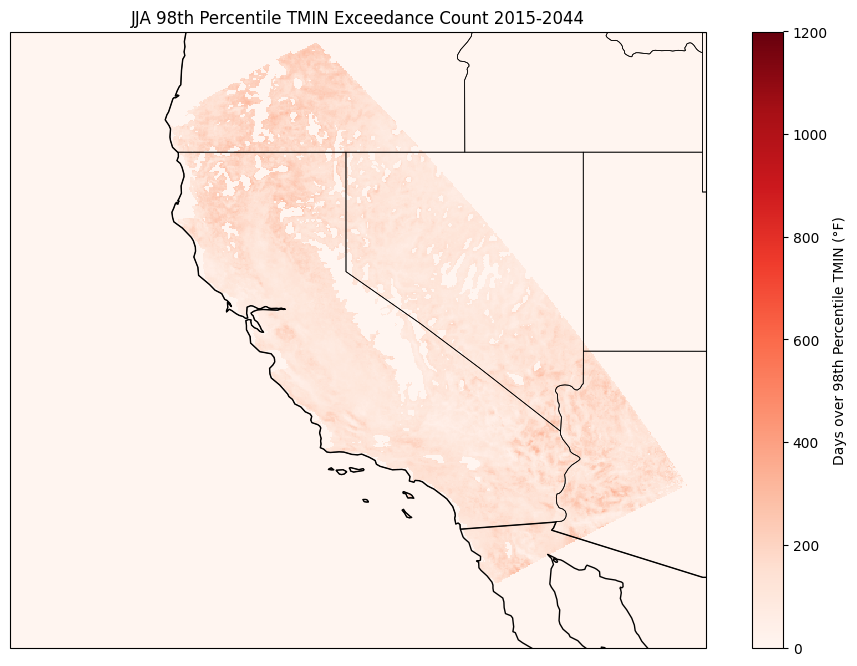

In [102]:
def map_98TMIN(netcdf_file, variable_name="tasmax_minus_tasmax_minus_tasmin", projection=ccrs.PlateCarree(), cmap='Reds'):
    """
    Creates a map of the Tasmin Exceedance Counts from a NetCDF file.

    Args:
        netcdf_file (str): Path to the NetCDF file containing the 100F counts.
        variable_name (str): Name of the variable to plot. Defaults to "tasmax".
        projection (cartopy.crs.Projection): Cartopy projection to use. Defaults to PlateCarree.
        cmap (str): Colormap to use. Defaults to 'RdBu_r'.
    """
    try:
        ds = xr.open_dataset(netcdf_file)
        data = ds[variable_name]

        if 'lat' not in data.coords or 'lon' not in data.coords:
            print("Error: Latitude and longitude coordinates not found.")
            ds.close()
            return

        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=projection)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap,vmax=1200, cbar_kwargs={'label': 'Days over 98th Percentile TMIN (°F)'})

        plt.title("JJA 98th Percentile TMIN Exceedance Count 2015-2044")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {netcdf_file}")
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in the file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'ds' in locals():
            ds.close()

# Example usage (assuming you have the tasmax_diff.nc file from the previous code):
netcdf_file_path = "VCP_EXHEAT_2A-5_98TMIN_counts_GT90F_2015-2044_MPI.nc"  # Path to the NetCDF file with the tasmax difference

map_98TMIN(netcdf_file_path)

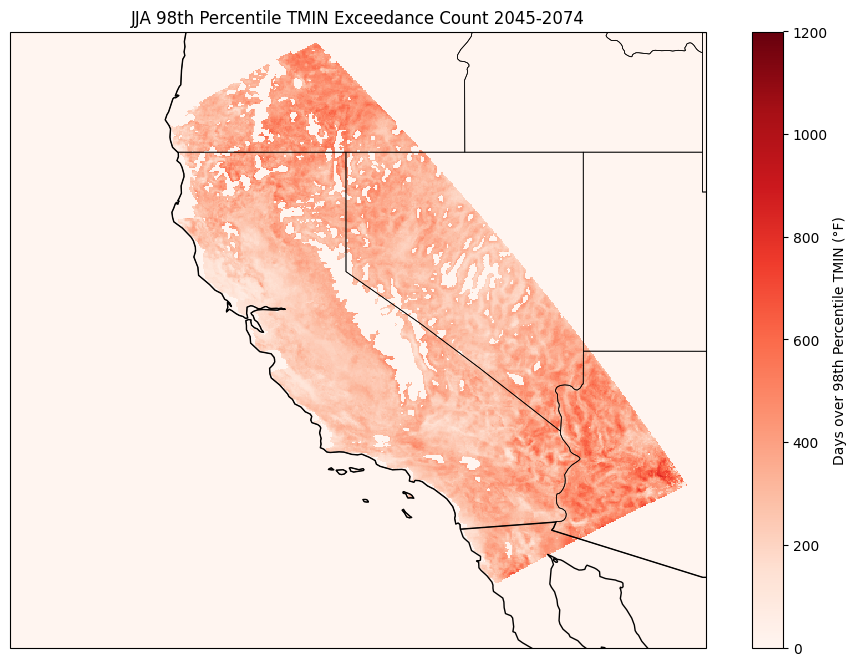

In [103]:
def map_98TMIN(netcdf_file, variable_name="tasmax_minus_tasmax_minus_tasmin", projection=ccrs.PlateCarree(), cmap='Reds'):
    """
    Creates a map of the Tasmin Exceedance Counts from a NetCDF file.

    Args:
        netcdf_file (str): Path to the NetCDF file containing the 100F counts.
        variable_name (str): Name of the variable to plot. Defaults to "tasmax".
        projection (cartopy.crs.Projection): Cartopy projection to use. Defaults to PlateCarree.
        cmap (str): Colormap to use. Defaults to 'RdBu_r'.
    """
    try:
        ds = xr.open_dataset(netcdf_file)
        data = ds[variable_name]

        if 'lat' not in data.coords or 'lon' not in data.coords:
            print("Error: Latitude and longitude coordinates not found.")
            ds.close()
            return

        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=projection)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap,vmax=1200,cbar_kwargs={'label': 'Days over 98th Percentile TMIN (°F)'})

        plt.title("JJA 98th Percentile TMIN Exceedance Count 2045-2074")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {netcdf_file}")
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in the file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'ds' in locals():
            ds.close()

# Example usage (assuming you have the tasmax_diff.nc file from the previous code):
netcdf_file_path = "VCP_EXHEAT_2A-5_98TMIN_counts_GT90F_2045-2074_MPI.nc"  # Path to the NetCDF file with the tasmax difference

map_98TMIN(netcdf_file_path)

In [ ]:
#Average 2015-2044 Data across 5 General Use Models

In [112]:
import xarray as xr
import glob # For finding files, or you can list them manually
import os

# --- Configuration ---

# 1. Specify the path to your NetCDF files
# Option A: Use a wildcard pattern if your files are in the same directory
file_pattern = "VCP_EXHEAT_2A*.nc" # IMPORTANT: Change this to your actual path and pattern
netcdf_files = sorted(glob.glob(file_pattern))

# Option B: Manually list the file paths
# netcdf_files = [
#     "/path/to/your/files/file1.nc",
#     "/path/to/your/files/file2.nc",
#     "/path/to/your/files/file3.nc",
#     "/path/to/your/files/file4.nc",
#     "/path/to/your/files/file5.nc",
# ] # IMPORTANT: Change these to your actual file paths

# Check if files were found (if using glob)
if not netcdf_files:
    print(f"No files found matching pattern: {file_pattern}")
    print("Or, if manually listing, ensure the list is not empty.")
    # exit() # Or handle as appropriate

print(f"Found files: {netcdf_files}")

# 2. Specify the name of the variable you want to average
# This variable must exist in all your NetCDF files.
variable_name = "tasmax_minus_tasmax_minus_tasmin"  # IMPORTANT: Change this (e.g., 'temperature', 'precipitation')

# 3. Specify the name of the dimension that the files will be concatenated along.
# If your files have a coordinate like 'time' and these times are different,
# xarray might automatically use that. If they are just 5 distinct files
# for the same grid without a distinguishing coordinate, open_mfdataset
# will create a new dimension, often 'concat_dim'.
# We will explicitly tell it to concatenate along a new dimension called 'file_dim'.
# This makes the averaging step clearer.
concatenation_dim = "file_index"

# 4. Specify the output file path
output_filename = "VCP_EXHEAT_02A_98TMIN_counts_GT90F_GENUSE-AVE_2015-2044.nc" # IMPORTANT: Change this
output_directory = os.path.dirname(output_filename)
if not os.path.exists(output_directory) and output_directory:
    os.makedirs(output_directory)
    print(f"Created output directory: {output_directory}")

# --- Processing ---

try:
    # 1. Load multiple NetCDF files
    # open_mfdataset can automatically combine files along a new or existing dimension.
    # We provide the list of files and tell it to concatenate them along our specified dimension.
    # We also pass preprocess if we want to ensure a consistent structure or select variables.
    def preprocess_for_mfdataset(ds):
        # Example: Select only the variable of interest to save memory,
        # or ensure the concatenation dimension doesn't already exist with a conflicting meaning.
        if variable_name not in ds.variables:
            raise ValueError(f"Variable '{variable_name}' not found in one of the files.")
        return ds[[variable_name]] # Keep only the target variable

    # If your files already have a 'time' dimension and you want to average over time:
    # ds_combined = xr.open_mfdataset(netcdf_files, combine='by_coords', parallel=True)
    # And then you would average over 'time':
    # averaged_data = ds_combined[variable_name].mean(dim='time')

    # For averaging across files where each file is a separate entity for the same grid:
    # We'll load them and concatenate them along a new dimension.
    list_of_datasets = [xr.open_dataset(f) for f in netcdf_files]

    # Check if all datasets have the required variable
    for i, ds_single in enumerate(list_of_datasets):
        if variable_name not in ds_single.variables:
            raise ValueError(f"Variable '{variable_name}' not found in file: {netcdf_files[i]}")

    # Concatenate along the new dimension
    ds_combined = xr.concat(list_of_datasets, dim=concatenation_dim)
    print("\nCombined dataset structure:")
    print(ds_combined)

    # 2. Calculate the average for each xy (lat/lon) location
    # The mean is calculated along the dimension that represents the different files.
    # If using open_mfdataset without a common coordinate like 'time', it often
    # creates a 'concat_dim'. If we used concat explicitly, it's 'file_index'.
    if variable_name in ds_combined:
        averaged_data_array = ds_combined[variable_name].mean(dim=concatenation_dim)
        print(f"\nCalculated average along dimension: '{concatenation_dim}'")
        print("\nAveraged data array structure:")
        print(averaged_data_array)
    else:
        raise ValueError(f"Variable '{variable_name}' not found in the combined dataset. Available variables: {list(ds_combined.data_vars)}")


    # 3. Prepare the dataset for export
    # The result of .mean() is a DataArray. We'll put it into a Dataset.
    # It's good practice to give the averaged variable a descriptive name
    # and copy relevant attributes.
    output_ds = xr.Dataset({f"{variable_name}_mean": averaged_data_array})

    # You might want to copy global attributes from one of the original files
    if list_of_datasets:
        output_ds.attrs = list_of_datasets[0].attrs
        output_ds.attrs['history'] = (
            f"Averaged from {len(netcdf_files)} files. "
            f"Original files pattern: {file_pattern if 'file_pattern' in locals() else 'manual list'}. "
            f"Averaged variable: {variable_name}."
        )
    if hasattr(averaged_data_array, 'attrs'):
        output_ds[f"{variable_name}_mean"].attrs = averaged_data_array.attrs
        output_ds[f"{variable_name}_mean"].attrs['long_name'] = f"Average of {averaged_data_array.attrs.get('long_name', variable_name)}"
        output_ds[f"{variable_name}_mean"].attrs['units'] = averaged_data_array.attrs.get('units', 'unknown')


    # Ensure latitude and longitude coordinates are preserved correctly.
    # If 'lat' and 'lon' were dimensions in the original files, they should be in averaged_data_array.
    # Example: if your coordinate names are different, adjust here.
    # output_ds = output_ds.rename({'latitude': 'lat', 'longitude': 'lon'}) # If needed

    print("\nOutput dataset structure:")
    print(output_ds)

    # 4. Export the file as NetCDF
    output_ds.to_netcdf(output_filename)
    print(f"\nSuccessfully saved averaged data to: {output_filename}")

except FileNotFoundError:
    print(f"Error: One or more input files not found. Please check paths: {netcdf_files}")
except ValueError as ve:
    print(f"ValueError: {ve}")
except KeyError as ke:
    print(f"KeyError: Likely an issue with variable or dimension names. {ke}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Found files: ['VCP_EXHEAT_2A-1_98TMIN_counts_GT90F_2015-2044.nc', 'VCP_EXHEAT_2A-2_98TMIN_counts_GT90F_2015-2044_Earth3.nc', 'VCP_EXHEAT_2A-3_98TMIN_counts_GT90F_2015-2044_FGOALS.nc', 'VCP_EXHEAT_2A-4_98TMIN_counts_GT90F_2015-2044_MIROC6.nc', 'VCP_EXHEAT_2A-5_98TMIN_counts_GT90F_2015-2044_MPI.nc']

Combined dataset structure:
<xarray.Dataset> Size: 6MB
Dimensions:                           (file_index: 5, lat: 495, lon: 559)
Coordinates:
  * lat                               (lat) float32 2kB 29.58 29.61 ... 45.02
  * lon                               (lon) float32 2kB 231.6 231.6 ... 249.0
    quantile                          float64 8B 0.98
Dimensions without coordinates: file_index
Data variables:
    tasmax_minus_tasmax_minus_tasmin  (file_index, lat, lon) int32 6MB 0 0 ... 0

Calculated average along dimension: 'file_index'

Averaged data array structure:
<xarray.DataArray 'tasmax_minus_tasmax_minus_tasmin' (lat: 495, lon: 559)> Size: 2MB
array([[0., 0., 0., ..., 0., 0., 0.],
   

In [ ]:
#Average 2045-2074 Data across 5 General Use Models

In [114]:
import xarray as xr
import glob # For finding files, or you can list them manually
import os

# --- Configuration ---

# 1. Specify the path to your NetCDF files
# Option A: Use a wildcard pattern if your files are in the same directory
file_pattern = "VCP_EXHEAT_2B*.nc" # IMPORTANT: Change this to your actual path and pattern
netcdf_files = sorted(glob.glob(file_pattern))

# Option B: Manually list the file paths
# netcdf_files = [
#     "/path/to/your/files/file1.nc",
#     "/path/to/your/files/file2.nc",
#     "/path/to/your/files/file3.nc",
#     "/path/to/your/files/file4.nc",
#     "/path/to/your/files/file5.nc",
# ] # IMPORTANT: Change these to your actual file paths

# Check if files were found (if using glob)
if not netcdf_files:
    print(f"No files found matching pattern: {file_pattern}")
    print("Or, if manually listing, ensure the list is not empty.")
    # exit() # Or handle as appropriate

print(f"Found files: {netcdf_files}")

# 2. Specify the name of the variable you want to average
# This variable must exist in all your NetCDF files.
variable_name = "tasmax_minus_tasmax_minus_tasmin"  # IMPORTANT: Change this (e.g., 'temperature', 'precipitation')

# 3. Specify the name of the dimension that the files will be concatenated along.
# If your files have a coordinate like 'time' and these times are different,
# xarray might automatically use that. If they are just 5 distinct files
# for the same grid without a distinguishing coordinate, open_mfdataset
# will create a new dimension, often 'concat_dim'.
# We will explicitly tell it to concatenate along a new dimension called 'file_dim'.
# This makes the averaging step clearer.
concatenation_dim = "file_index"

# 4. Specify the output file path
output_filename = "VCP_EXHEAT_02B_98TMIN_counts_GT90F_GENUSE-AVE_2045-2074.nc" # IMPORTANT: Change this
output_directory = os.path.dirname(output_filename)
if not os.path.exists(output_directory) and output_directory:
    os.makedirs(output_directory)
    print(f"Created output directory: {output_directory}")

# --- Processing ---

try:
    # 1. Load multiple NetCDF files
    # open_mfdataset can automatically combine files along a new or existing dimension.
    # We provide the list of files and tell it to concatenate them along our specified dimension.
    # We also pass preprocess if we want to ensure a consistent structure or select variables.
    def preprocess_for_mfdataset(ds):
        # Example: Select only the variable of interest to save memory,
        # or ensure the concatenation dimension doesn't already exist with a conflicting meaning.
        if variable_name not in ds.variables:
            raise ValueError(f"Variable '{variable_name}' not found in one of the files.")
        return ds[[variable_name]] # Keep only the target variable

    # If your files already have a 'time' dimension and you want to average over time:
    # ds_combined = xr.open_mfdataset(netcdf_files, combine='by_coords', parallel=True)
    # And then you would average over 'time':
    # averaged_data = ds_combined[variable_name].mean(dim='time')

    # For averaging across files where each file is a separate entity for the same grid:
    # We'll load them and concatenate them along a new dimension.
    list_of_datasets = [xr.open_dataset(f) for f in netcdf_files]

    # Check if all datasets have the required variable
    for i, ds_single in enumerate(list_of_datasets):
        if variable_name not in ds_single.variables:
            raise ValueError(f"Variable '{variable_name}' not found in file: {netcdf_files[i]}")

    # Concatenate along the new dimension
    ds_combined = xr.concat(list_of_datasets, dim=concatenation_dim)
    print("\nCombined dataset structure:")
    print(ds_combined)

    # 2. Calculate the average for each xy (lat/lon) location
    # The mean is calculated along the dimension that represents the different files.
    # If using open_mfdataset without a common coordinate like 'time', it often
    # creates a 'concat_dim'. If we used concat explicitly, it's 'file_index'.
    if variable_name in ds_combined:
        averaged_data_array = ds_combined[variable_name].mean(dim=concatenation_dim)
        print(f"\nCalculated average along dimension: '{concatenation_dim}'")
        print("\nAveraged data array structure:")
        print(averaged_data_array)
    else:
        raise ValueError(f"Variable '{variable_name}' not found in the combined dataset. Available variables: {list(ds_combined.data_vars)}")


    # 3. Prepare the dataset for export
    # The result of .mean() is a DataArray. We'll put it into a Dataset.
    # It's good practice to give the averaged variable a descriptive name
    # and copy relevant attributes.
    output_ds = xr.Dataset({f"{variable_name}_mean": averaged_data_array})

    # You might want to copy global attributes from one of the original files
    if list_of_datasets:
        output_ds.attrs = list_of_datasets[0].attrs
        output_ds.attrs['history'] = (
            f"Averaged from {len(netcdf_files)} files. "
            f"Original files pattern: {file_pattern if 'file_pattern' in locals() else 'manual list'}. "
            f"Averaged variable: {variable_name}."
        )
    if hasattr(averaged_data_array, 'attrs'):
        output_ds[f"{variable_name}_mean"].attrs = averaged_data_array.attrs
        output_ds[f"{variable_name}_mean"].attrs['long_name'] = f"Average of {averaged_data_array.attrs.get('long_name', variable_name)}"
        output_ds[f"{variable_name}_mean"].attrs['units'] = averaged_data_array.attrs.get('units', 'unknown')


    # Ensure latitude and longitude coordinates are preserved correctly.
    # If 'lat' and 'lon' were dimensions in the original files, they should be in averaged_data_array.
    # Example: if your coordinate names are different, adjust here.
    # output_ds = output_ds.rename({'latitude': 'lat', 'longitude': 'lon'}) # If needed

    print("\nOutput dataset structure:")
    print(output_ds)

    # 4. Export the file as NetCDF
    output_ds.to_netcdf(output_filename)
    print(f"\nSuccessfully saved averaged data to: {output_filename}")

except FileNotFoundError:
    print(f"Error: One or more input files not found. Please check paths: {netcdf_files}")
except ValueError as ve:
    print(f"ValueError: {ve}")
except KeyError as ke:
    print(f"KeyError: Likely an issue with variable or dimension names. {ke}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Found files: ['VCP_EXHEAT_2B-1_98TMIN_counts_GT90F_2045-2074.nc', 'VCP_EXHEAT_2B-2_98TMIN_counts_GT90F_2045-2074_Earth3.nc', 'VCP_EXHEAT_2B-3_98TMIN_counts_GT90F_2045-2074_FGOALS.nc', 'VCP_EXHEAT_2B-4_98TMIN_counts_GT90F_2045-2074_MIROC6.nc', 'VCP_EXHEAT_2B-5_98TMIN_counts_GT90F_2045-2074_MPI.nc']

Combined dataset structure:
<xarray.Dataset> Size: 6MB
Dimensions:                           (file_index: 5, lat: 495, lon: 559)
Coordinates:
  * lat                               (lat) float32 2kB 29.58 29.61 ... 45.02
  * lon                               (lon) float32 2kB 231.6 231.6 ... 249.0
    quantile                          float64 8B 0.98
Dimensions without coordinates: file_index
Data variables:
    tasmax_minus_tasmax_minus_tasmin  (file_index, lat, lon) int32 6MB 0 0 ... 0

Calculated average along dimension: 'file_index'

Averaged data array structure:
<xarray.DataArray 'tasmax_minus_tasmax_minus_tasmin' (lat: 495, lon: 559)> Size: 2MB
array([[0., 0., 0., ..., 0., 0., 0.],
   

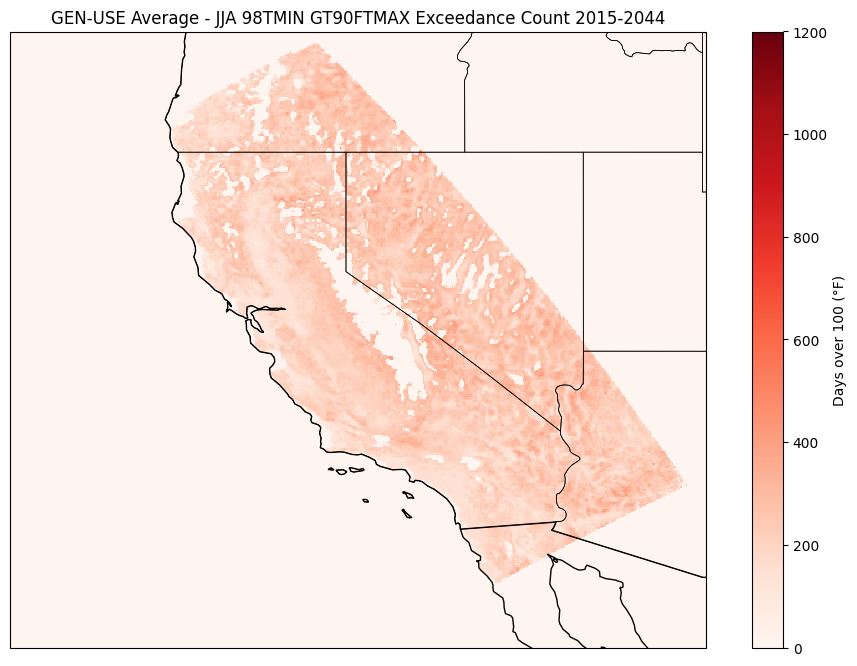

In [13]:
def map_100F(netcdf_file, variable_name="tasmax_minus_tasmax_minus_tasmin_mean", projection=ccrs.PlateCarree(), cmap='Reds'):
    """
    Creates a map of the 100F Exceedance Counts from a NetCDF file.

    Args:
        netcdf_file (str): Path to the NetCDF file containing the 100F counts.
        variable_name (str): Name of the variable to plot. Defaults to "tasmax".
        projection (cartopy.crs.Projection): Cartopy projection to use. Defaults to PlateCarree.
        cmap (str): Colormap to use. Defaults to 'RdBu_r'.
    """
    try:
        ds = xr.open_dataset(netcdf_file)
        data = ds[variable_name]

        if 'lat' not in data.coords or 'lon' not in data.coords:
            print("Error: Latitude and longitude coordinates not found.")
            ds.close()
            return

        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=projection)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, vmax=1200,cbar_kwargs={'label': 'Days over 100 (°F)'})

        plt.title("GEN-USE Average - JJA 98TMIN GT90FTMAX Exceedance Count 2015-2044")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {netcdf_file}")
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in the file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'ds' in locals():
            ds.close()

# Example usage (assuming you have the tasmax_diff.nc file from the previous code):
netcdf_file_path = "VCP_EXHEAT_02A_98TMIN_counts_GT90F_GENUSE-AVE_2015-2044.nc"  # Path to the NetCDF file with the tasmax difference

map_100F(netcdf_file_path)

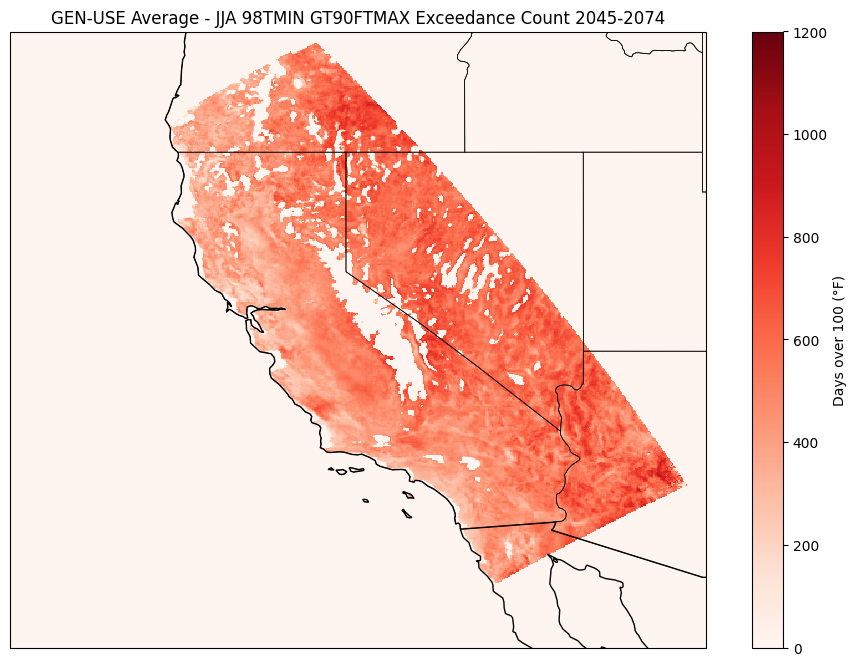

In [118]:
def map_100F(netcdf_file, variable_name="tasmax_minus_tasmax_minus_tasmin_mean", projection=ccrs.PlateCarree(), cmap='Reds'):
    """
    Creates a map of the 100F Exceedance Counts from a NetCDF file.

    Args:
        netcdf_file (str): Path to the NetCDF file containing the 100F counts.
        variable_name (str): Name of the variable to plot. Defaults to "tasmax".
        projection (cartopy.crs.Projection): Cartopy projection to use. Defaults to PlateCarree.
        cmap (str): Colormap to use. Defaults to 'RdBu_r'.
    """
    try:
        ds = xr.open_dataset(netcdf_file)
        data = ds[variable_name]

        if 'lat' not in data.coords or 'lon' not in data.coords:
            print("Error: Latitude and longitude coordinates not found.")
            ds.close()
            return

        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=projection)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, vmax=1200,cbar_kwargs={'label': 'Days over 100 (°F)'})

        plt.title("GEN-USE Average - JJA 98TMIN GT90FTMAX Exceedance Count 2045-2074")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {netcdf_file}")
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in the file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'ds' in locals():
            ds.close()

# Example usage (assuming you have the tasmax_diff.nc file from the previous code):
netcdf_file_path = "VCP_EXHEAT_02B_98TMIN_counts_GT90F_GENUSE-AVE_2045-2074.nc"  # Path to the NetCDF file with the tasmax difference

map_100F(netcdf_file_path)